# Adversarial Search: Playing "Mean" Connect 4


## Instructions

All student names in group: James Nanas, Zachary Lowinger, Stanley Yu

I understand that my submission needs to be my own group's work: JN, ZL, SY

I understand that ChatGPT / Copilot / other AI tools are not allowed: JN, ZL, SY

Points: 10

Complete this notebook and submit it (save/print as pdf). The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it back in the top of the same column. All disks above the removed disk will fall down one position and the removed one will be placed on top. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board. **Further, you are not allowed to play a mean move if your opponent just played one.** This ensures the game will end at some point. This also may affect the definition of a state, compared with standard Connect 4.

If a mean move causes both players to win, the game immediately ends and it is a tie, even if one player has more connect-4s than the other one. If a mean move causes one player to win, then the game also ends and the player with the connect-4 is the winner.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

Initial State: A blank board of a certain size (e.g. 6,7), and which 2 players (or agents ) shall pick a color to use, and it is agreed that one player go first.

Actions: If there are spaces left, each player chooses a spot to place their chip in, provided that this spot has no empty spaces below it and is not occupied. Additionally, they may choose to either play a "Mean" move, if the previous move by the other player is not a "Mean" move, where the player chooses a column, where the chip on the bottom row is removed, saved, the entire column shifted down by 1, then the chip saved put back on the top of that column.

Transition Model: The board with the new move played, provided that the move played is a valid one

Test for Terminal State: A function that returns "win", None (Loss), "Tie" , or False, depending on the given state of the board

Utility for Terminal State: This shall return 1 for Red, -1 for yellow, 0 for tie, None for Not terminal state

How big is the state space? Give an estimate and explain it.

The state space shall be the number of possible moves that can be made in the game. For example, with a blank board, the player can have c number of columns as moves to place their chip in the game. Additionally, there can be 1 extra move if a "Mean" move is utilised, provided that there are chips in the game and that the "Mean" move is valid. Thus, the maximum amount of possible moves that can be done is c+1, where c is the number of columns. c decreases with each column filled out, with additional 1 possible move subtracted from it if a "Mean" move cannot be done, all the way down to 0 moves if there is a Terminal state.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

The game tree would contain about ((number of cols)**number of rows) nodes since for each possible move you can have a maximum of the number of column, until either a column is full, or there is a pressing need to block the other player from winning (or there are no choices). This leads for number of cols moves maximum per initial move, down to 0 in the final tree.

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [3]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(state, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

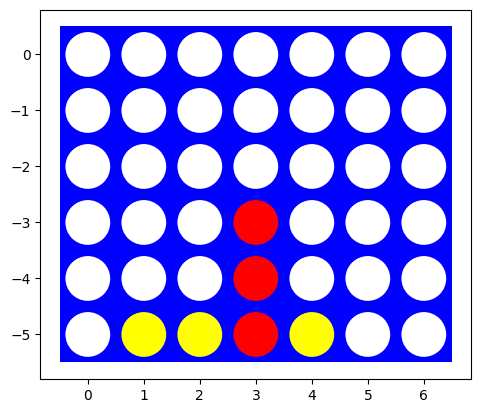

In [4]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [5]:
# Your code/ answer goes here.


def result(s,a):
    #a is the action, is a tuple of (player,type, (row,column)) or (player, type, column)
    #s is the state, is tuple of (board, isLastMoveMean)

    player, actionType, pos = a
    board, isLastMoveMean = s

    #player should be 1 or -1
    #actionType should be normal or mean
    #column should be 0 to n

    if actionType == 'normal': #Drop piece to bottom of column
        board[pos[1]][pos[0]] = player #Place piece
        isLastMoveMean = False
    else: #Do mean move, move bottom piece to top, need to shuffle all pieces down
        isLastMoveMean = True
        pieceToMove = board[-1][pos]  #get piece to move

        for i in range(len(board) - 1, 0, -1):
            board[i][pos] = board[i - 1][pos] #Shift pieces
        board[0][pos] = 0

        for i in range(1, len(board)): #Move the piece
            if board[i][pos] != 0:
                board[i-1][pos] = pieceToMove
                break
        else:
            board[-1][pos] = pieceToMove #Place the piece at the bottom


    return  (board,isLastMoveMean) #New state

def utility(s,p):
    #Given s see who wins
    #Game is over if 4 in row/col/dig (1 player wins), 4 in row/col/dig (tie from mean move), or no more moves (tie)
    board, isLastMoveMean = s

    player1Win = False
    player2Win = False

    #Row

    #Use a sliding window of 4

    for i in range(len(board)): #Should check for multi wins
        for j in range(len(board[i])-3):
            if (board[i][j] != 0) and (board[i][j] == board[i][j+1]) and (board[i][j] == board[i][j+2]) and (board[i][j] == board[i][j+3]):
                if board[i][j] == 1:
                    player1Win = True
                else:
                    player2Win = True

    #Column
    for i in range(len(board)-3): #Should check for multi wins
        for j in range(len(board[i])):
            if (board[i][j] != 0) and (board[i][j] == board[i+1][j]) and (board[i][j] == board[i+2][j]) and (board[i][j] == board[i+3][j]):
                if board[i][j] == 1:
                    player1Win = True
                else:
                    player2Win = True

    #Upward diagonal
    for i in range(len(board)-3):
        for j in range(len(board[i])-3):
            if (board[i][j] != 0) and (board[i][j] == board[i+1][j+1]) and (board[i][j] == board[i+2][j+2]) and (board[i][j] == board[i+3][j+3]):
                if board[i][j] == 1:
                    player1Win = True
                else:
                    player2Win = True

    #Downward diagonal
    for i in range(len(board)-3):
        for j in range(3, len(board[i])):
            if (board[i][j] != 0) and (board[i][j] == board[i+1][j-1]) and (board[i][j] == board[i+2][j-2]) and (board[i][j] == board[i+3][j-3]):
                if board[i][j] == 1:
                    player1Win = True
                else:
                    player2Win = True

    #See if there is a win
    if player1Win == True and player2Win == True:
        return 0.5
    elif player1Win == True:
        if p == 1:
            return 1
        else:
            return 0
    elif player2Win == True:
        if p == 1:
            return 0
        else:
            return 1


    #If there is a mean move still open then game is not over
    if isLastMoveMean == False and player1Win == False and player2Win == False:
        return None #Game is not over no utility yet any win

    #If no mean move check if board is full
    for i in range(len(board)):
        for j in range(len(board[i])):
            if board[i][j] == 0:
                return None

    #Board is full, no win, and no mean move
    return 0.5

def terminal(s):
    #Given s see if game is over
    #Game is over if 4 in row/col/dig (1 player wins), 4 in row/col/dig (tie from mean move), or no more moves (tie)
    board, isLastMoveMean = s

    #Row

    #Use a sliding window of 4

    for i in range(len(board)): #Should check for multi wins
        for j in range(len(board[i])-3):
            if (board[i][j] != 0) and (board[i][j] == board[i][j+1]) and (board[i][j] == board[i][j+2]) and (board[i][j] == board[i][j+3]):
                return True

    #Column
    for i in range(len(board)-3): #Should check for multi wins
        for j in range(len(board[i])):
            if (board[i][j] != 0) and (board[i][j] == board[i+1][j]) and (board[i][j] == board[i+2][j]) and (board[i][j] == board[i+3][j]):
                return True

    #Upward diagonal
    for i in range(len(board)-3):
        for j in range(len(board[i])-3):
            if (board[i][j] != 0) and (board[i][j] == board[i+1][j+1]) and (board[i][j] == board[i+2][j+2]) and (board[i][j] == board[i+3][j+3]):
                return True

    #Downward diagonal
    for i in range(len(board)-3):
        for j in range(3, len(board[i])):
            if (board[i][j] != 0) and (board[i][j] == board[i+1][j-1]) and (board[i][j] == board[i+2][j-2]) and (board[i][j] == board[i+3][j-3]):
                return True

    #If there is a mean move still open then game is not over
    if isLastMoveMean == False:
        return False #Still at least one move

    #If no mean move check if board is full
    for i in range(len(board)):
        for j in range(len(board[i])):
            if board[i][j] == 0:
                return False

    #Board is full, no win, and no mean move
    return True



def actions(s):
    #Given s return all actions
    #s is tuple of (board, isLastMoveMean)
    board, isLastMoveMean = s
    actions = [] #Will be list of tuples of (type, (column, row)) or (type, column)

    #If first row is not full can do normal move, should be always able to do mean move
    for i in range(len(board[0])):
        if board[0][i] == 0:
            #Possible to do normal move now find where piece will land
            for j in range(len(board)-1, -1, -1):
                if board[j][i] == 0:
                    actions.append(('normal', (i, j)))
                    break
        if isLastMoveMean == False: #Can only do mean move if last move was not mean
            actions.append(('mean', i))

    return actions




Implement an agent that plays randomly. Make sure the agent function receives as the percept the game state and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(state, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on by the environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [6]:
# Your code/ answer goes here.

def random_player(state, player = None):
    #Get actions and pick random action
    playerActions = actions(state)
    randPick = np.random.randint(0, len(playerActions))
    randAction = playerActions[randPick]

    #Add player to action
    aType, pos = randAction
    randActionPlayer = (player, aType, pos)
    return randActionPlayer

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [7]:
# Your code/ answer goes here.

player1Wins = 0
player2Wins = 0
ties = 0

for i in range (1000):
    s = empty_board()
    state = (s, False)
    player = 1
    while terminal(state) == False:
        if player == 1:
            state = result(state, random_player(state, player=player))
        else:
            state = result(state, random_player(state, player=player))
        player = player * -1

    #Game has ended
    u = utility(state, 1)
    if u == 1:
        player1Wins += 1
    elif u == 0:
        player2Wins += 1
    else:
        ties += 1

print("Player 1 wins: ", player1Wins)
print("Player 2 wins: ", player2Wins)
print("Ties: ", ties)


Player 1 wins:  495
Player 2 wins:  487
Ties:  18


## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given state and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [8]:
# Your code/ answer goes here.

import copy

def other(player):
    if player == 1: return -1
    else: return 1

def random_player_normal(state, player=None):
    # Get actions normal
    normal_actions = []
    for aType, pos in actions(state):
        if aType == 'normal':
            normal_actions.append((aType, pos))
    if len(normal_actions) > 0:
        randAction = np.random.randint(0, len(normal_actions))
        randAction = normal_actions[randAction]
        randActionPlayer = (player, randAction[0], randAction[1])
        return randActionPlayer
    else:
        return None

def minimaxPlayer(state, player,):
    depth = 3
    value, move = maxValue(state, player, alpha= float('-inf'), beta = float('inf'), depth = depth)
    if move is None:
        return random_player_normal(state, player)
    return move

def maxValue(state,player, alpha, beta, depth):
    value = utility(state, player)
    if value is not None:
        return value, None

    if depth == 0:
        return value, None

    value, move = float('-inf'), None

    for a in actions(state):
        a = (player, a[0], a[1])
        value2, move2 = minValue(result(copy.deepcopy(state), a), player, alpha, beta, depth-1)
        if value2 is not None and value2 > value:
            value, move = value2, a
            alpha = max(alpha, value)

        if value >= beta:
            return value, move

    return value, move

def minValue(state,player, alpha, beta, depth):
    value = utility(state, player)
    if value is not None:
        return value, None

    if depth == 0:
        return value, None

    value, move = float('inf'), None

    for a in actions(state):
        a = (other(player), a[0], a[1])
        value2, move2 = maxValue(result(copy.deepcopy(state), a), player, alpha, beta, depth-1)
        if value2 is not None and value2 < value:
            value, move = value2, a
            beta = min(beta, value)
        if value <= alpha:
            return value, move

    return value, move



Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [9]:
# With depth locked at 3
#4x4 boards

board1 = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 1, 1, 1]
        ]

state1 = (board1, False)
print(minimaxPlayer(state1, 1))

board2 = [[0, 0, 0, 0],
          [-1, 1, 0, 0],
          [-1, -1, 1, 0],
          [-1, -1, -1, 1]
        ]

state2 = (board2, False)
print(minimaxPlayer(state2, 1))

board3 = [[-1, 0, 0, 0],
          [1, 0, 0, 0],
          [1, 0, 0, 0],
          [-1, 1, 1, 1]
        ]

state3 = (board3, False)
print(minimaxPlayer(state3, 1))

board4 = [[0, 0, 0, 0],
          [0, 0, 0, 1],
          [0, 0, 0, 1],
          [0, 0, 0, 1]
        ]

state4 = (board4, False)
print(minimaxPlayer(state4, 1))

board5 = [[0, 0, 0, 0],
          [0, 0, 1, -1],
          [0, 1, -1, -1],
          [1, -1, -1, -1]
        ]

state5 = (board5, False)
print(minimaxPlayer(state5, 1))


(1, 'normal', (0, 3))
(1, 'normal', (0, 0))
(1, 'mean', 0)
(1, 'normal', (3, 0))
(1, 'normal', (3, 0))


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [10]:
#Locking the depth at 3, it takes

import time

start = time.time()

board1 = [[0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 1, 1, 1]
            ]

state1 = (board1, False)
print(minimaxPlayer(state1, 1))

end = time.time()

print(f"Time taken for 4x4 board: {(end-start) * 1e3} ms")

start = time.time()

#Normal board size

board1 = [[0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0]]

state1 = (board1, False)
print(minimaxPlayer(state1, 1))

end = time.time()

print(f"Time taken for 6x7 board: {(end-start) * 1e3} ms")

(1, 'normal', (0, 3))
Time taken for 4x4 board: 2.0003318786621094 ms
(1, 'normal', (3, 2))
Time taken for 6x7 board: 12.999773025512695 ms


### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move.

In [11]:
# Your code/ answer goes here.

#Redifine actions

def actionsPrio(s):
    #Given s return all actions
    #s is tuple of (board, isLastMoveMean)
    board, isLastMoveMean = s
    actions = [] #Will be list of tuples of (type, (column, row)) or (type, column)

    priority = [ #Best is regular moves in the middle
    ('normal', (2,0)), ('normal', (3,0)), ('normal', (4,0)),
    ('normal', (2,1)), ('normal', (3,1)), ('normal', (4,1)),
    ('normal', (2,2)), ('normal', (3,2)), ('normal', (4,2)),
    ('normal', (2,3)), ('normal', (3,3)), ('normal', (4,3)),
    ('normal', (2,4)), ('normal', (3,4)), ('normal', (4,4)),
    ('normal', (2,5)), ('normal', (3,5)), ('normal', (4,5)),
    ]

    #If first row is not full can do normal move, should be always able to do mean move
    for i in range(len(board[0])):
        if board[0][i] == 0:
            #Possible to do normal move now find where piece will land
            for j in range(len(board)-1, -1, -1):
                if board[j][i] == 0:
                    actions.append(('normal', (i, j)))
                    break
        if isLastMoveMean == False: #Can only do mean move if last move was not mean
            actions.append(('mean', i))

    #Sort actions by priority
    actions.sort(key=lambda x: priority.index(x) if x in priority else len(priority))

    return actions

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

In [12]:
# Your code/ answer goes here.

#In the worst possible case, this algorithm will run through all possible moves every time.
#To fix this problem, we could use a table of the best start moves for the first few moves
#This will save time in the beginning of the game where computation takes the most time.
#Then later in the game, we can use the minimax algorithm to find the best move since there are less possible moves to make.


### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

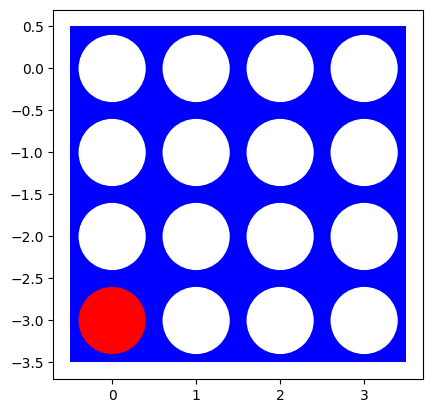

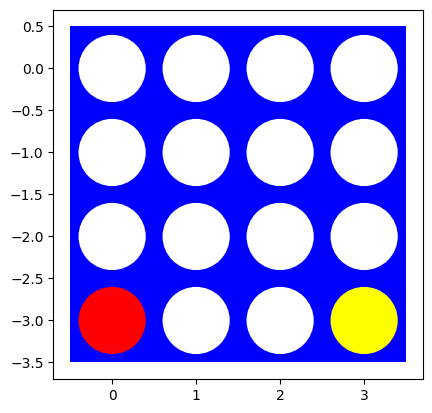

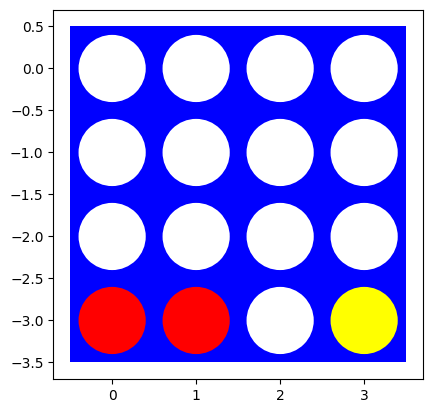

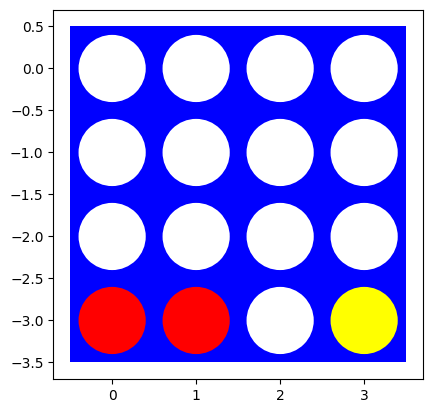

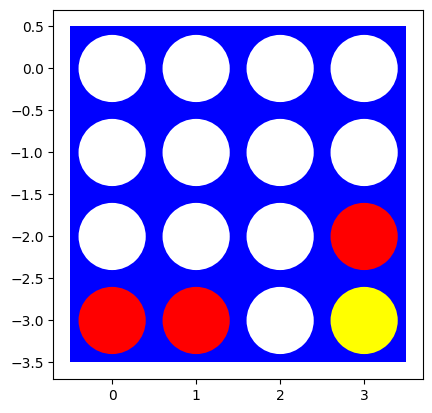

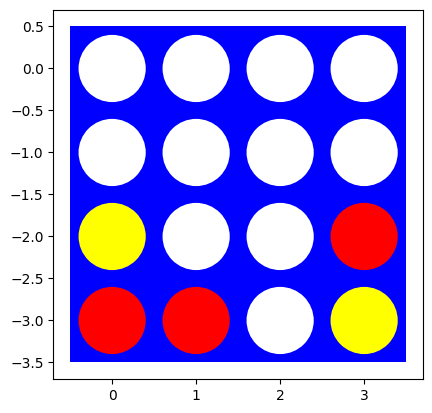

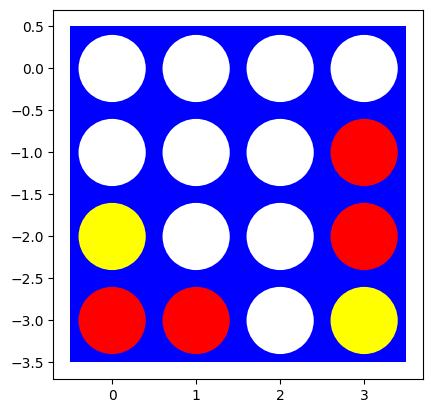

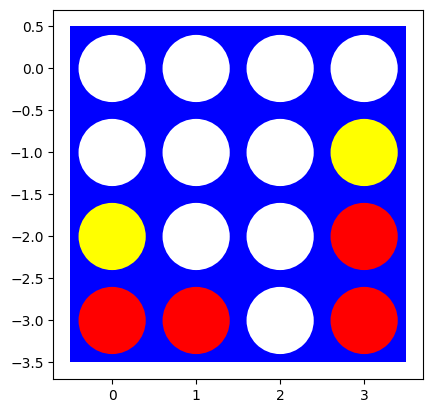

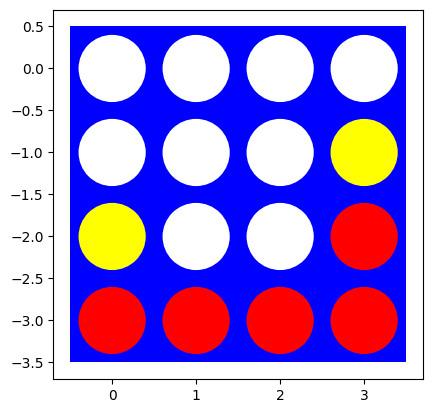

In [13]:
# Your code/ answer goes here.

board = [
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
        ]

state = (board, False)

#print(minimax_player(state, 1, 4)) #Should be (1, 'normal', (2, 0))

while terminal(state) == False:
    state = result(state, minimaxPlayer(state, 1))
    visualize(state[0])
    if terminal(state) == True:
        break
    state = result(state, random_player(state, -1))
    visualize(state[0])

## Task 4: Heuristic Alpha-Beta Tree Search [3 points]

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [14]:
# Your code/ answer goes here.

def evalFunc(state, player):

    #if terminal return utility
    u = utility(state, player)
    if u is not None:
        return u, True

    #Want to set up 3 in a row for player and block 3 in a row for other player
    #Count number of 3 in a row for player and other player

    board, isLastMoveMean = state
    player3InRow = 0
    other3InRow = 0

    #Row

    #Use a sliding window of 3

    for i in range(len(board)): #Count both players
        for j in range(len(board[i])-2):
            if (board[i][j] != 0) and (board[i][j] == board[i][j+1]) and (board[i][j] == board[i][j+2]):
                if board[i][j] == player:
                    player3InRow += 1
                else:
                    other3InRow += 5

    #Column

    for i in range(len(board)-2): #Count both players
        for j in range(len(board[i])):
            if (board[i][j] != 0) and (board[i][j] == board[i+1][j]) and (board[i][j] == board[i+2][j]):
                if board[i][j] == player:
                    player3InRow += 1
                else:
                    other3InRow += 5

    #Upward diagonal

    for i in range(len(board)-2):
        for j in range(len(board[i])-2):
            if (board[i][j] != 0) and (board[i][j] == board[i+1][j+1]) and (board[i][j] == board[i+2][j+2]):
                if board[i][j] == player:
                    player3InRow += 1
                else:
                    other3InRow += 5

    #Downward diagonal

    for i in range(len(board)-2):
        for j in range(2, len(board[i])):
            if (board[i][j] != 0) and (board[i][j] == board[i+1][j-1]) and (board[i][j] == board[i+2][j-2]):
                if board[i][j] == player:
                    player3InRow += 1
                else:
                    other3InRow += 5

    return player3InRow + other3InRow, False



### Cutting off search

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [15]:
# Your code/ answer goes here.

def minimaxPlayerDepthHeur(state, player, depth):
    value, move = maxValueDepthHeur(state, player, float('-inf'), float('inf'), depth)
    if move is None:
        return random_player_normal(state, player)
    return move

def maxValueDepthHeur(state,player, alpha, beta, depth):
    value, terminal = evalFunc(state, player)
    if(terminal == True):
            alpha, beta = value, value

    if (depth == 0) or (terminal == True):
        return value, None

    value, move = float('-inf'), None

    #for a in actionsPrio(state):
    for a in actions(state):
        a = (player, a[0], a[1])
        value2, move2 = minValueDepthHeur(result(copy.deepcopy(state), a), player, alpha, beta, depth-1)
        if value2 is not None and value2 > value:
            value, move = value2, a
            alpha = max(alpha, value)

        if value >= beta:
            return value, move

    return value, move

def minValueDepthHeur(state,player, alpha, beta, depth):
    value, terminal = evalFunc(state, player)
    if(terminal == True):
            alpha, beta = value, value
    if (depth == 0) or (terminal == True):
        return value, None

    value, move = float('inf'), None

    #for a in actionsPrio(state):
    for a in actions(state):
        a = (other(player), a[0], a[1])
        value2, move2 = maxValueDepthHeur(result(copy.deepcopy(state), a), player, alpha, beta, depth-1)
        if value2 is not None and value2 < value:
            value, move = value2, a
            beta = min(beta, value)
        if value <= alpha:
            return value, move

    return value, move

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [16]:
# With depth of 6
#4x4 boards

board1 = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 1, 1, 1]
        ]

state1 = (board1, False)
print(minimaxPlayerDepthHeur(state1, 1, 3))

board2 = [[0, 0, 0, 0],
          [-1, 1, 0, 0],
          [-1, -1, 1, 0],
          [-1, -1, -1, 1]
        ]

state2 = (board2, False)
print(minimaxPlayerDepthHeur(state1, 2, 4))

board3 = [[-1, 0, 0, 0],
          [1, 0, 0, 0],
          [1, 0, 0, 0],
          [-1, 1, 1, 1]
        ]

state3 = (board3, False)
print(minimaxPlayerDepthHeur(state3, 1, 4))

board4 = [[0, 0, 0, 0],
          [0, 0, 0, 1],
          [0, 0, 0, 1],
          [0, 0, 0, 1]
        ]

state4 = (board4, False)
print(minimaxPlayerDepthHeur(state4, 1, 4))

board5 = [[0, 0, 0, 0],
          [0, 0, 1, -1],
          [0, 1, -1, -1],
          [1, -1, -1, -1]
        ]

state5 = (board5, False)
print(minimaxPlayerDepthHeur(state5, 1, 4))


(1, 'normal', (0, 3))
(2, 'normal', (0, 3))
(1, 'mean', 0)
(1, 'normal', (0, 3))
(1, 'normal', (3, 0))


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [17]:
# Your code/ answer goes here.

#Locking the depth at 3, it takes

import time

start = time.time()

board1 = [[0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 1, 1, 1]
            ]

state1 = (board1, False)
print(minimaxPlayerDepthHeur(state1, 1, 6))

end = time.time()

print(f"Time taken for 4x4 board: {(end-start) * 1e3} ms")

start = time.time()

#Normal board size

board1 = [[0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0]]

state1 = (board1, False)
print(minimaxPlayerDepthHeur(state1, 1,6))

end = time.time()

print(f"Time taken for 6x7 board: {(end-start) * 1e3} ms")



(1, 'normal', (1, 2))
Time taken for 4x4 board: 46.99826240539551 ms
(1, 'normal', (0, 5))
Time taken for 6x7 board: 1541.0583019256592 ms


### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

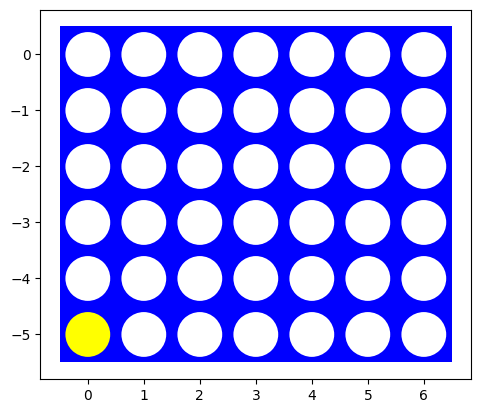

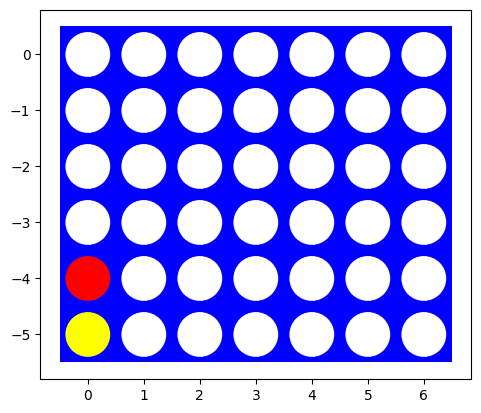

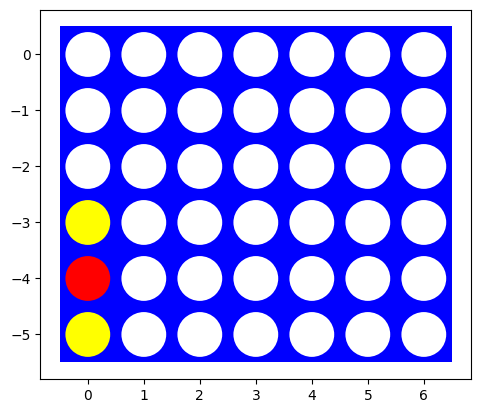

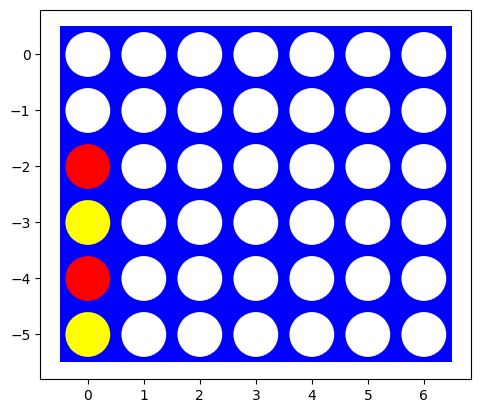

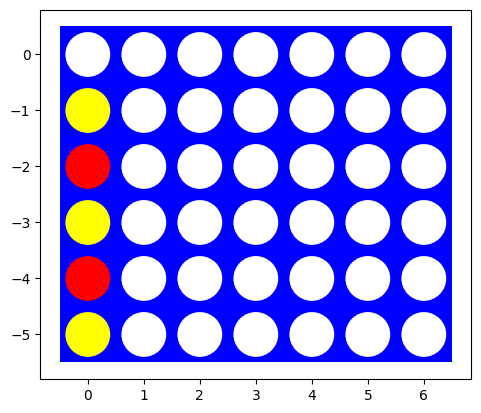

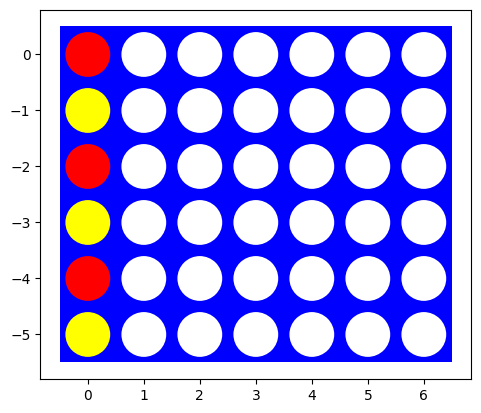

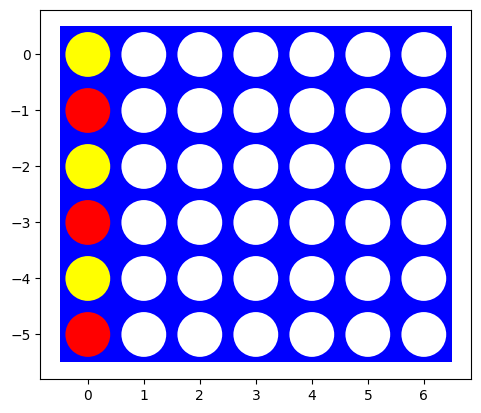

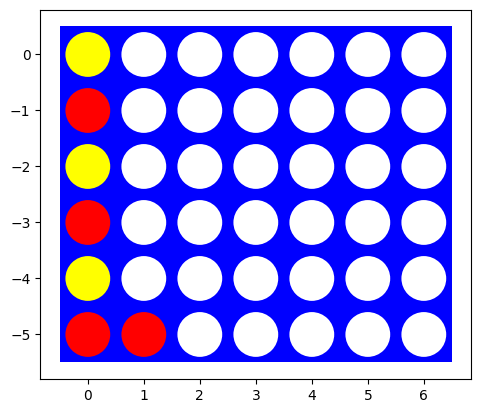

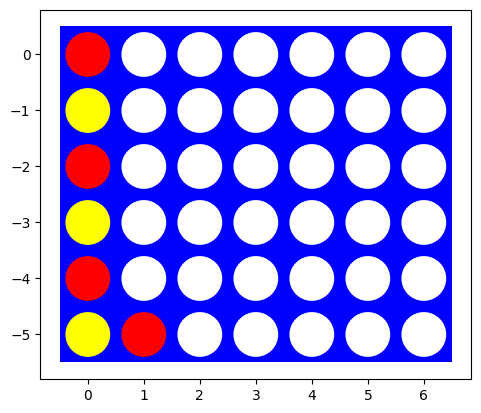

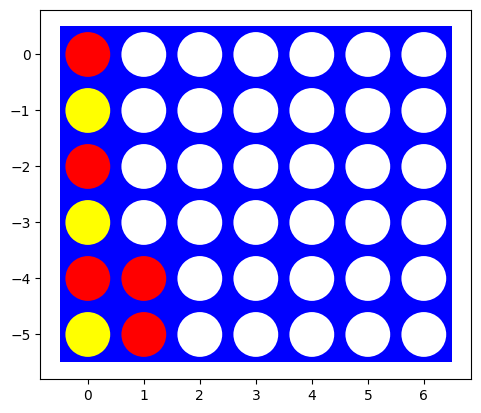

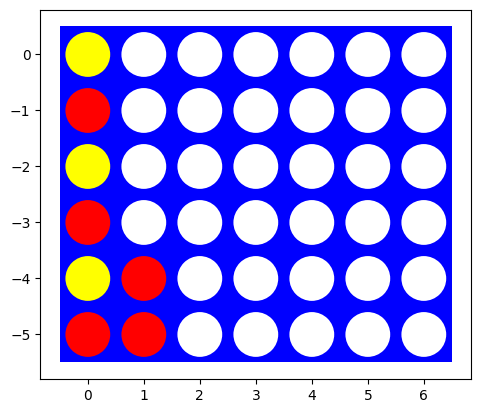

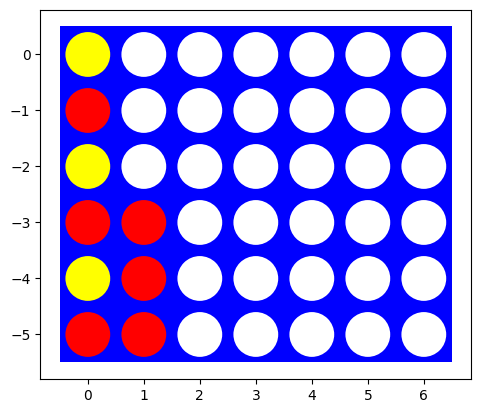

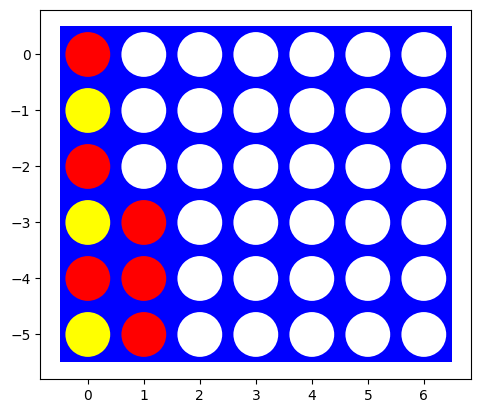

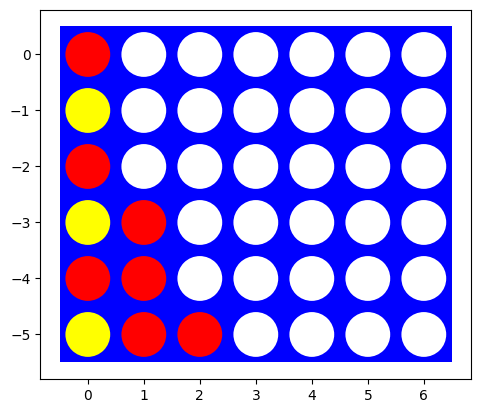

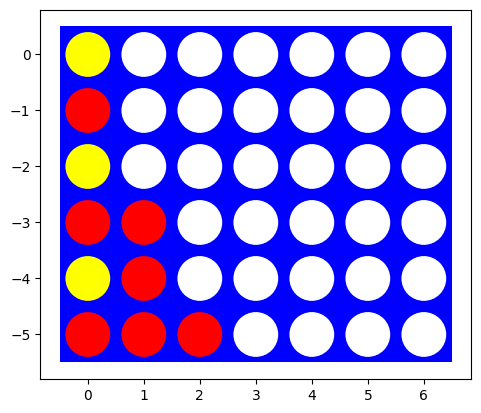

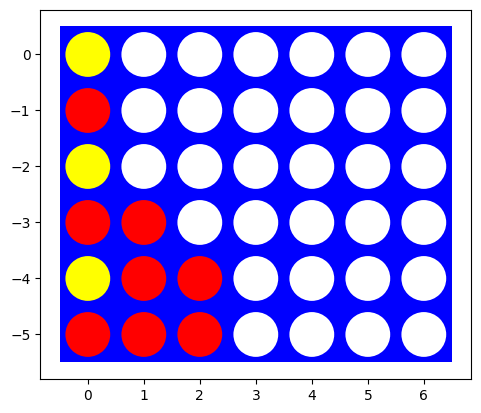

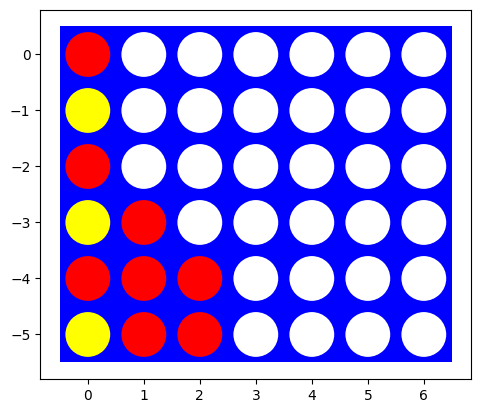

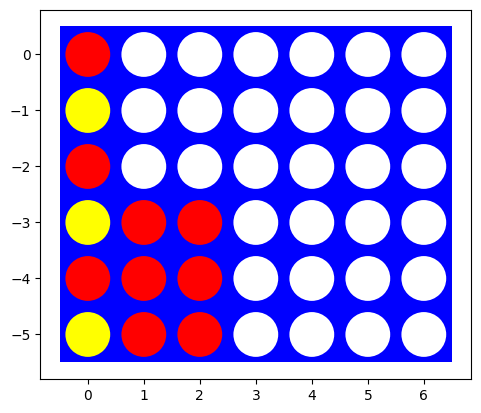

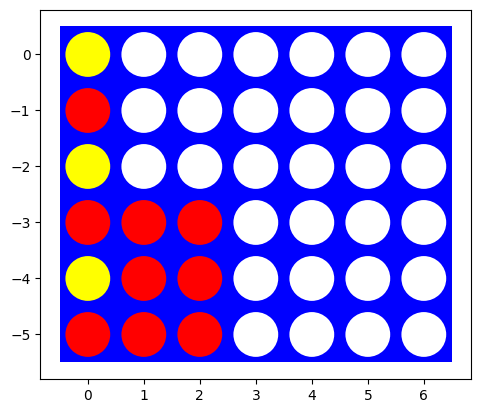

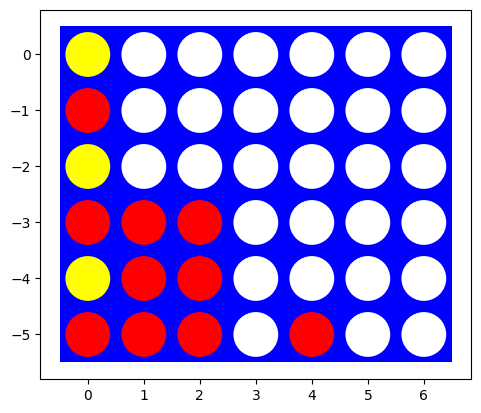

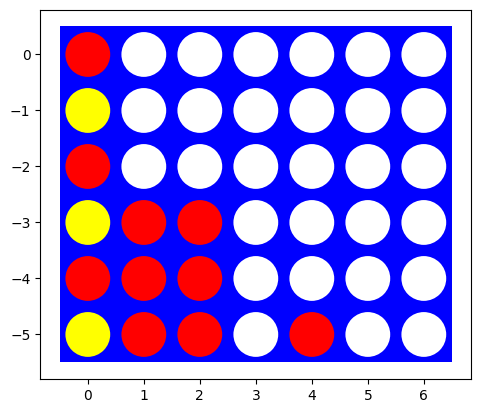

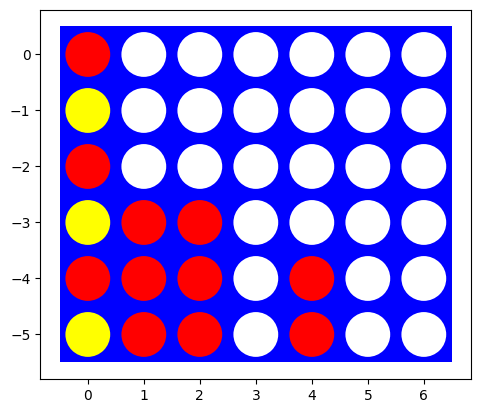

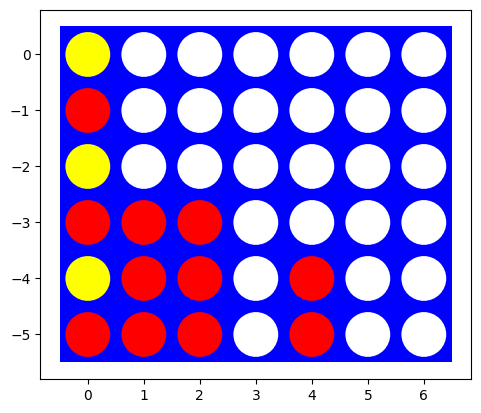

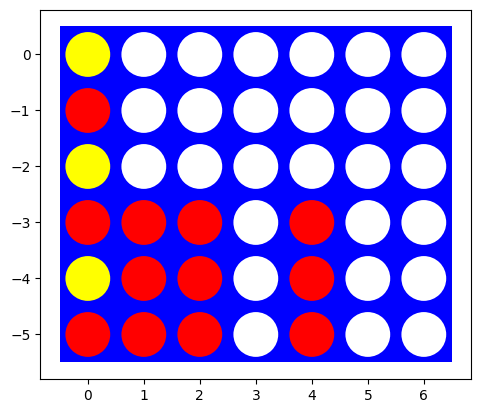

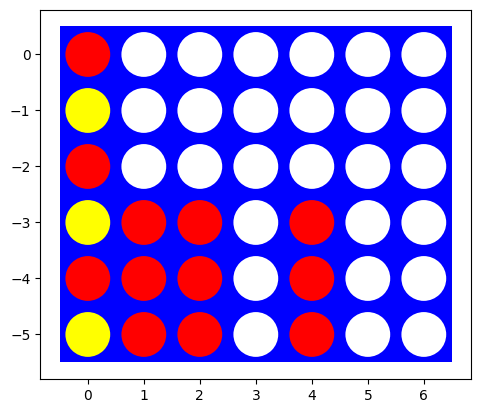

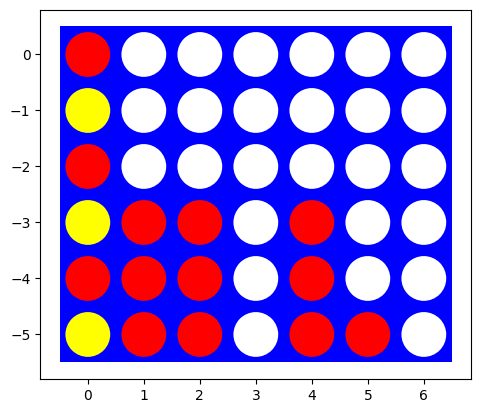

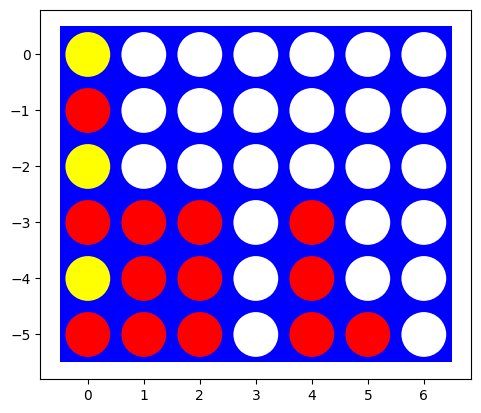

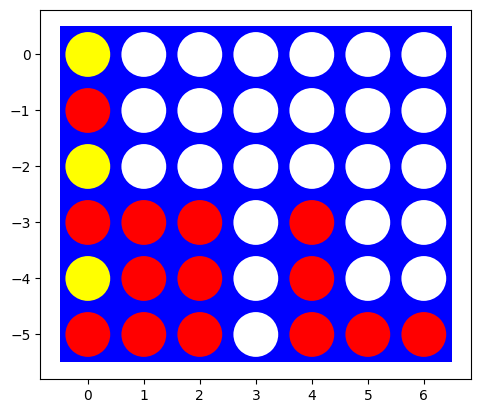

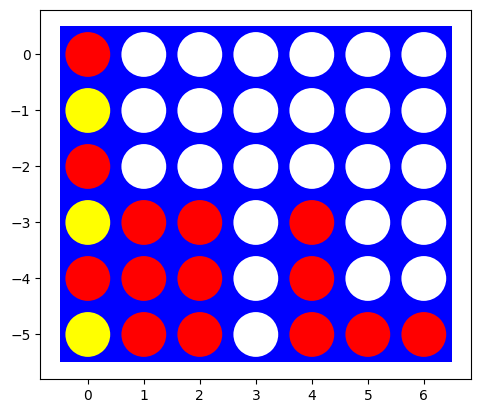

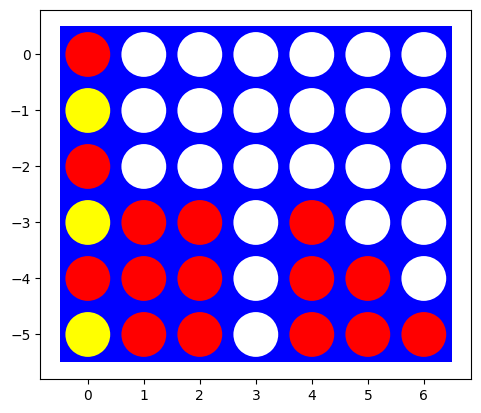

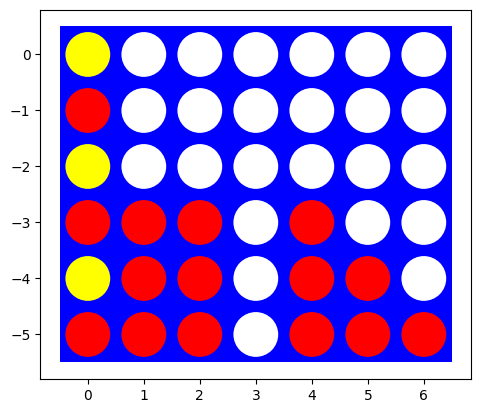

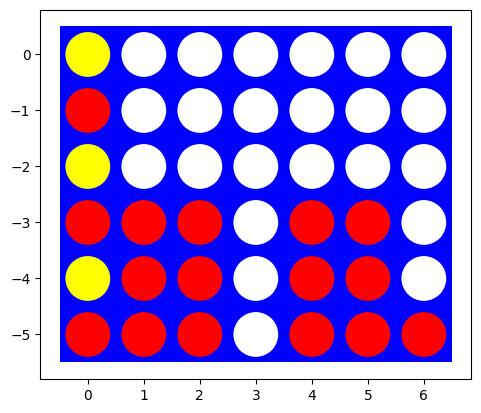

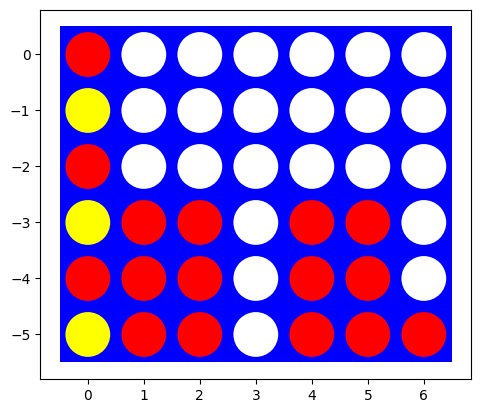

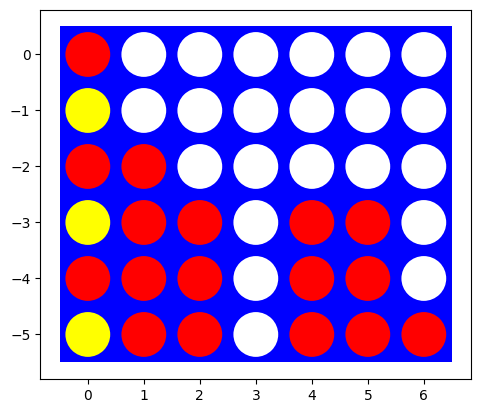

In [18]:
# Your code/ answer goes here.

board = [
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]
        ]

state = (board, False)


while terminal(state) == False:
    state = result(state, minimaxPlayerDepthHeur(state, -1, 6))
    visualize(state[0])
    if terminal(state) == True:
        break
    state = result(state, minimaxPlayerDepthHeur(state, 1, 6))
    visualize(state[0])

---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.
